A complete dataset of socio-demographic data per ZIPCODE (UHFs) of New York city had been built using different sources as nyc.gov Open Data, data of New York city, 5 years survay of Census Bureau, NYC Health department website for the data referring to Covid-19 testing and ; for this purpose the avaiable code related to the paper "Assessing capacity to social distance and neighborhood-level health disparities during the COVID-19 pandemic" (doi: https://doi.org/10.1101/2020.06.02.20120790) has been used.

In our cases, NYC Health department data are updated at the 1st October, before the second round of infections.
Positive cases per zipcode refers to the number of people in that census tract, indicated as ZCTA, that had result positive to the antibody test: this type of test can find out if someone has ever had the virus.

Here is presented an analysis of the data.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import numpy as np
import statsmodels.api as ssm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
data_per_zcta = pd.read_csv("/home/claudia/Scrivania/Tesi NYC pandemic /COVID_19_data_Rstudio/Complete_data_per_zipcodes.csv")

x_shapes = gpd.read_file("/home/claudia/Scrivania/Tesi NYC pandemic /COVID_19_data_Rstudio/shapes/shapes.shp")
x_shapes['zcta']=pd.to_numeric(x_shapes['zcta'])

complete_data_per_zcta = x_shapes.merge(data_per_zcta, on='zcta') #file data with geoometry information

In [3]:
complete_data_per_zcta.rename(columns={'Positive': 'Positive cases'}, inplace=True)
complete_data_per_zcta.rename(columns={'Total': 'Total tests'}, inplace=True)
complete_data_per_zcta.rename(columns={'modzcta_cum_perc_pos': 'Perc Positive'}, inplace=True)
complete_data_per_zcta.rename(columns={'total_commute1': 'Tot commuters'}, inplace=True)
complete_data_per_zcta.rename(columns={'not_insured': 'Perc of not insured'}, inplace=True)

data_per_zcta.rename(columns={'Positive': 'Positive cases'}, inplace=True)
data_per_zcta.rename(columns={'Total': 'Total tests'}, inplace=True)
data_per_zcta.rename(columns={'modzcta_cum_perc_pos': 'Perc Positive'}, inplace=True)
data_per_zcta.rename(columns={'total_commute1': 'Tot commuters'}, inplace=True)
data_per_zcta.rename(columns={'not_insured': 'Perc of not insured'}, inplace=True)
#not_quarantined_jobs refers to an estimates of workers still moving to go to workplace

data_per_zcta.drop(['zcta', 'median_rent', 'valid_var','total_res_volume_zcta'], axis='columns', inplace=True)

Using as reference the study on the different socio-demographiv and economic variables at zcta-level related to the social disadvantage, we focus on the variables that are more correlated to the number of positive cases (as index of infection at ZCTA-level) and then we would like to do a Multiple Linear Regression on these significative variables to predict the outcome variable value on which we can focus: positive cases per ZCTA.

We use at first Pearson’s Correlation Coefficient: it is known as the best method of measuring the association between variables of interest because it is based on the method of covariance.  It gives information about the magnitude of the association, or correlation, as well as the direction of the relationship.

In our case, we've chosen to focus on medium-high level of correlation with the number of positive cases, in a range [$\pm$ 0.45:$\pm$ 1], obviously getting rid of variables obviously related to this number such as: percentage of positives, positives per 100k persons, total number of workers, population and households, number of total tests in each zcta.

I won't consider variables such as SNAP households (means portion of households that rely on Supplemental nutrition Assistance program) or flp_150, indicating the portion of population below 150% of Federal poverty level are strongly correlated to median income values.

As in article "Assessing capacity to social distance and neighborhood-level health disparities during the COVID-19 pandemic", it would be reasonable to try to include in a unique index these variables.

In [25]:
corr_matrix = data_per_zcta.corr() #Using Pearson's coefficient
type(corr_matrix)

corr_matrix.to_csv("/home/claudia/Scrivania/Tesi NYC pandemic /COVID_19_data_Rstudio/corr_matrix1.csv")

#inserire immagine jpg da excel o table or heathmap without numbers

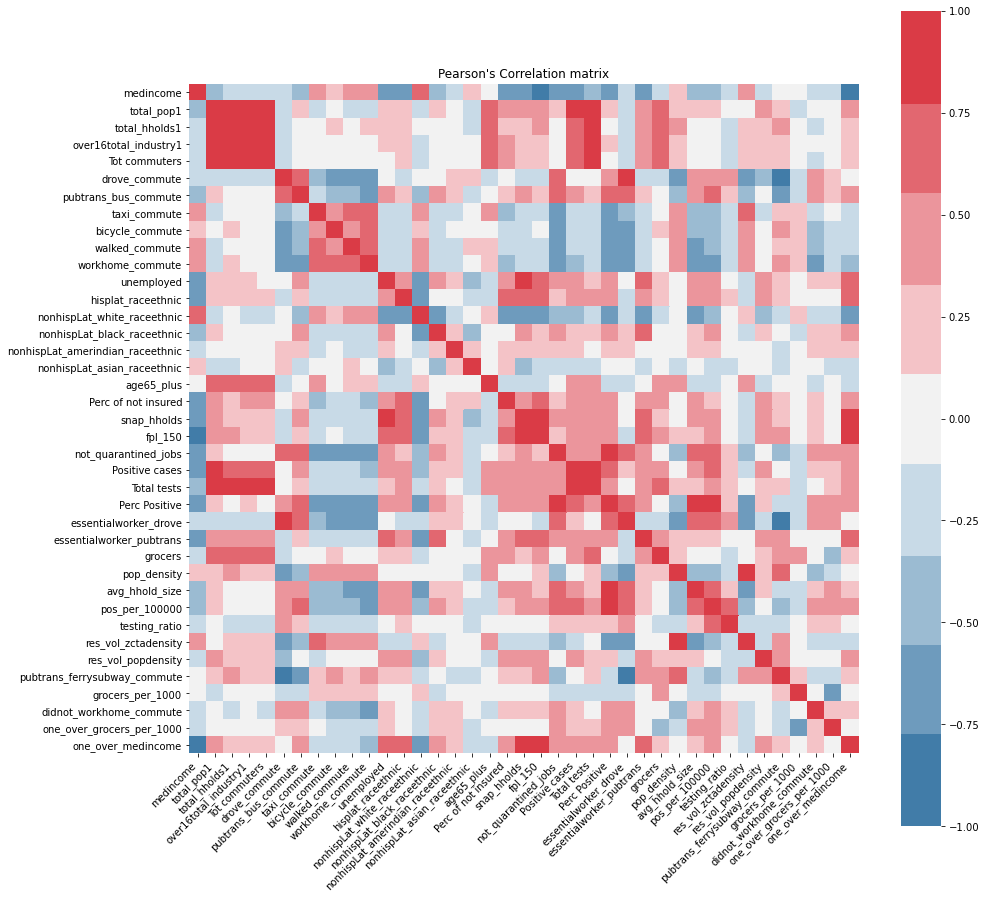

In [5]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(240, 10, n=9),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

ax.set_title("Pearson's Correlation matrix");

In [6]:
print(corr_matrix['Positive cases']) #can be insert as a jpg file 
#corr_matrix

medincome                          -0.555823
total_pop1                          0.845194
total_hholds1                       0.672714
over16total_industry1               0.733922
Tot commuters                       0.727285
drove_commute                       0.060135
pubtrans_bus_commute                0.367615
taxi_commute                       -0.290707
bicycle_commute                    -0.276682
walked_commute                     -0.273520
workhome_commute                   -0.390306
unemployed                          0.377390
hisplat_raceethnic                  0.448620
nonhispLat_white_raceethnic        -0.468141
nonhispLat_black_raceethnic         0.266035
nonhispLat_amerindian_raceethnic    0.137950
nonhispLat_asian_raceethnic        -0.173085
age65_plus                          0.345729
Perc of not insured                 0.484701
snap_hholds                         0.529130
fpl_150                             0.511245
not_quarantined_jobs                0.497094
Positive c

### Construction of an "Infection Index"

The choice of variables that most reppresent an indicator of social disadvantage related to the incidence of Covid-19, looking at the Pearson's correlation coefficient with the number of positive cases , are:

- total number of commuters (+0.73);
- percentage of workers commuting using public transports (+0.53);
- percentage of not covered by healt insurance (+0.48)
- one over median income (+0.49) [using the idea of the reciprocal as in the paper]
- averege number of persons per houshold (+0.47)

As first approach, I've tried to construct an infection index to predict the number of positive cases to covid-19 per zipcode: an average index and a weighted one. The latter has been construct using as a weight for each variable a mapping based on the values of the correlations coefficient. (Look at the excel file in the github named "Data_per_zipcodes_index_analysis".

Once the index has been created, I've done a linear regression to predict the output variable per zip code and looking at the $R^2$, I've pointed out that the best perform was given by the one with the "weighted index",

After this previous analysis, here we've performed a MULTIVARIATE LINEAR REGRESSION, considering the whole set of the five variables included in the index construction to have a better prediction of the number of positive cases and to identify an evidence of association between these socio-demographic factors at ZCTA-level and the differences in Covid-19 incidence.

In [7]:
#corr_matrix_kendall = data_per_zcta.corr(method='kendall')
print(corr_matrix['pos_per_100000']) #consider the number of positive per 100K people, using fraction more correct

medincome                          -0.548587
total_pop1                          0.138290
total_hholds1                      -0.066365
over16total_industry1              -0.008188
Tot commuters                      -0.016206
drove_commute                       0.527686
pubtrans_bus_commute                0.629362
taxi_commute                       -0.466885
bicycle_commute                    -0.548543
walked_commute                     -0.532918
workhome_commute                   -0.645949
unemployed                          0.385496
hisplat_raceethnic                  0.437741
nonhispLat_white_raceethnic        -0.541408
nonhispLat_black_raceethnic         0.351590
nonhispLat_amerindian_raceethnic    0.214968
nonhispLat_asian_raceethnic        -0.197133
age65_plus                         -0.162959
Perc of not insured                 0.324531
snap_hholds                         0.402952
fpl_150                             0.329469
not_quarantined_jobs                0.740557
Positive c

Looking at correlation values with the number of positive cases per 100000 persons:

Variables chosen that represent a good social disadvantage indicator, based on Pearson's correlation coefficient:

- number of commuters using public transports (+0.63);
- percentage of workers commuting by driving (+0.59);
- percentage of not covered by healt insurance (+0.32)
- one over median income (+0.42) [using the idea of the reciprocal as in the paper]
- averege number of persons per houshold (+0.64)


### Multivariate linear regression on Positive cases  and Perc Positive

Assumptions to apply multivariate linear regression:

- the output Y (Positive cases) must be in a linear relationship with each variable considered.
- once done the multivariate regression, errors between observed and predicted values (i.e., the residuals of the  regression) should be normally distributed;
- correlations coefficients between the input variables X should be lowe then 80% (no multicollinearity);
- model shouldn't be homoscedastic, i.e. there shouldn't not be a clear pattern between "residuals" and predicted values of the model, using the calculated coefficients.

Text(0.5, 0.98, 'Assumption 1 Multivariate linear reg.')

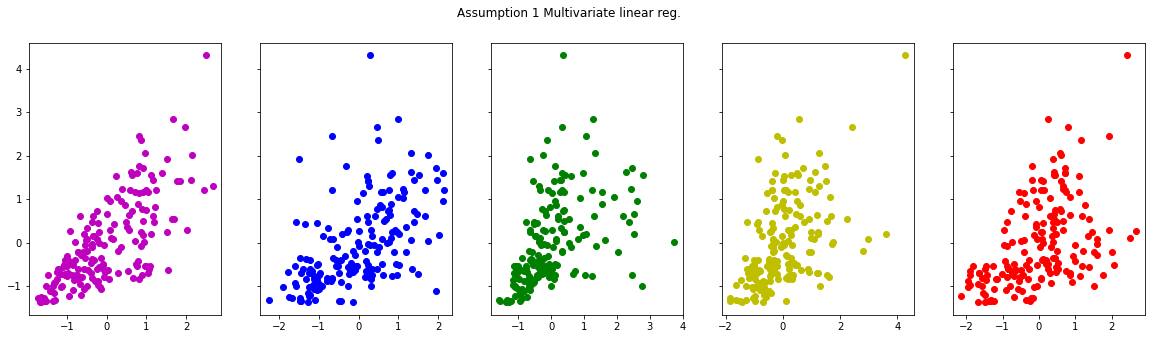

In [8]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)


axs[0].scatter(preprocessing.scale(data_per_zcta['Tot commuters']), preprocessing.scale(data_per_zcta['Positive cases']), s=None, c='m', marker=None)
axs[1].scatter(preprocessing.scale(data_per_zcta['essentialworker_pubtrans']), preprocessing.scale(data_per_zcta['Positive cases']), s=None, c='b', marker=None)
axs[2].scatter(preprocessing.scale(data_per_zcta['one_over_medincome']), preprocessing.scale(data_per_zcta['Positive cases']), s=None, c='g', marker=None)
axs[3].scatter(preprocessing.scale(data_per_zcta['Perc of not insured']), preprocessing.scale(data_per_zcta['Positive cases']), s=None, c='y', marker=None)
axs[4].scatter(preprocessing.scale(data_per_zcta['avg_hhold_size']), preprocessing.scale(data_per_zcta['Positive cases']), s=None, c='r', marker=None)

fig.suptitle('Assumption 1 Multivariate linear reg.')

Performing a first multivariate linear regression with data of positive cases per zcta in NYC.

In [9]:
#dataframe of variables of our interest with standardized data

tot_commuters_st = preprocessing.scale(data_per_zcta['Tot commuters'])
workers_pubtrans_st= preprocessing.scale(data_per_zcta['essentialworker_pubtrans'])
one_over_medincome_st = preprocessing.scale(data_per_zcta['one_over_medincome'])
Perc_not_insured_st = preprocessing.scale(data_per_zcta['Perc of not insured'])
avg_hholes_size_st= preprocessing.scale(data_per_zcta['avg_hhold_size'])
pos_cases_st = preprocessing.scale(data_per_zcta['Positive cases'])

data_st = {'Zcta' : complete_data_per_zcta["zcta"],
            'Tot commuters' : tot_commuters_st, 
            'workers_pubtrans' : workers_pubtrans_st,
            'one_over_medincome' : one_over_medincome_st,
            'Not insured perc' : Perc_not_insured_st, 
            'Avg households size' : avg_hholes_size_st,
            'Positive cases' : pos_cases_st}

df = pd.DataFrame(data_st)

In [10]:
#define randomly the trainset and dataset
train, test = train_test_split(df, test_size=0.25)

regr = linear_model.LinearRegression()

X_train = train[["Tot commuters", "workers_pubtrans", "one_over_medincome", "Not insured perc", "Avg households size"]]
y_train = train["Positive cases"]

regr.fit(X_train, y_train)

LinearRegression()

In [11]:
# Create the test features dataset (X_test) which will be used to make the predictions.

X_test = test[["Tot commuters", "workers_pubtrans", "one_over_medincome", "Not insured perc", "Avg households size"]].values 
y_test = test["Positive cases"].values

close_predictions = regr.predict(X_test)


MSE: 0.18582432301565663
RMSE: 0.4310734543156846
R^2 : 0.7770082139823269


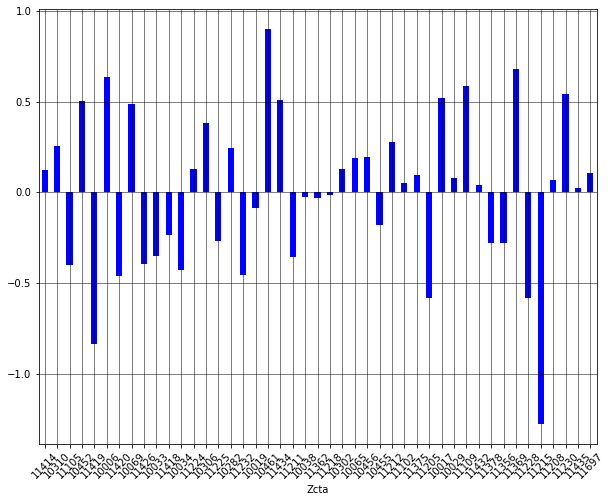

In [12]:
#mean square error 

print("MSE:", mean_squared_error(y_test,close_predictions))
print("RMSE:", np.sqrt(mean_squared_error(y_test,close_predictions)))

r_square =r2_score(y_test,close_predictions)
print("R^2 :", r_square)

# Create a dataframe that output the Date, the Actual and the predicted value

df_output = pd.DataFrame({'Zcta': test['Zcta'] ,'Actual': y_test, 'Predicted': close_predictions})
df_output.set_index('Zcta',inplace=True)
 
error = df_output['Actual'] - df_output['Predicted']
 
# Plot the error term between the actual and predicted values

error.plot(kind='bar',figsize=(10,8), color='b')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xticks(rotation=45)
plt.show()


Perform a better multivariate linear regression (looking at $R^2$ value) using the data of percentage of positive tested to antibody test per zcta. This is not totally correct because Person's coefficient are different

In [13]:
perc_pos_cases_st = preprocessing.scale(data_per_zcta['Perc Positive'])

data2_st = {'Zcta' : complete_data_per_zcta["zcta"],
            'Tot commuters' : tot_commuters_st, 
            'workers_pubtrans' : workers_pubtrans_st,
            'one_over_medincome' : one_over_medincome_st,
            'Not insured perc' : Perc_not_insured_st, 
            'Avg households size' : avg_hholes_size_st,
            'Perc positive cases' : perc_pos_cases_st}

df2 = pd.DataFrame(data2_st)

In [14]:
#define randomly the trainset and dataset
train2, test2 = train_test_split(df2, test_size=0.2)

regr2 = linear_model.LinearRegression()

X_train2 = train2[["Tot commuters", "workers_pubtrans", "one_over_medincome", "Not insured perc", "Avg households size"]]
y_train2 = train2["Perc positive cases"]

regr.fit(X_train2, y_train2)

LinearRegression()

In [15]:
# Create the test features dataset (X_test) which will be used to make the predictions.
X_test2 = test2[["Tot commuters", "workers_pubtrans", "one_over_medincome", "Not insured perc", "Avg households size"]].values 
y_test2 = test2["Perc positive cases"].values

close_predictions2 = regr.predict(X_test2)

MSE: 0.29368044216550426
RMSE: 0.5419229116447323
R^2 : 0.7251642599885686


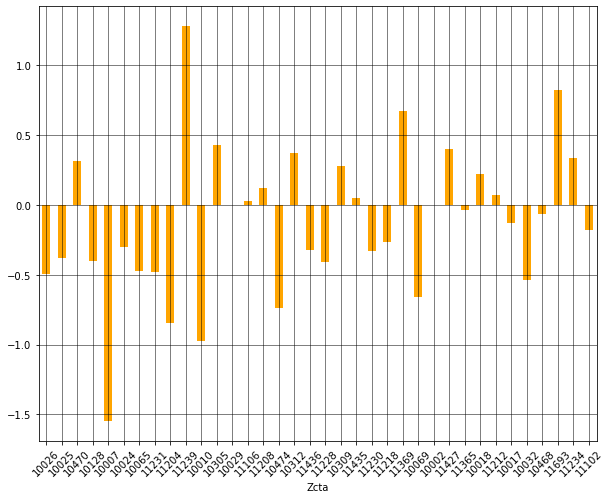

In [16]:
print("MSE:", mean_squared_error(y_test2,close_predictions2))
print("RMSE:", np.sqrt(mean_squared_error(y_test2,close_predictions2)))

r_square2 =r2_score(y_test2,close_predictions2)
print("R^2 :", r_square2)

# Create a dataframe that output the Date, the Actual and the predicted value

df_output2 = pd.DataFrame({'Zcta': test2['Zcta'] ,'Actual': y_test2, 'Predicted': close_predictions2})
df_output2.set_index('Zcta',inplace=True)
 
error_2 = df_output2['Actual'] - df_output2['Predicted']
 
# Plot the error term between the actual and predicted values
error_2.plot(kind='bar',figsize=(10,8), color='Orange')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xticks(rotation=45)
plt.show()

### Multivariate linear regression on Positive per 100000 persons

This multivariate linear regression is more correct from the previous ones in a sense that we're going to consider more appropriately the fraction of persons per zcta that has been result positive to the antibody test.

Still applying the multivariate linear regression assumptions, with the five chosen variables:

- the output Y ('pos_per_100000' in the dataframe) must be in a linear relationship with each variable considered.
- once done the multivariate regression, errors between observed and predicted values (i.e., the residuals of the  regression) should be normally distributed;
- correlations coefficients between the input variables X should be lowe then 80% (no multicollinearity);
- model shouldn't be homoscedastic, i.e. there shouldn't not be a clear pattern between "residuals" and predicted values of the model, using the calculated coefficients.

Text(0.5, 0.98, 'Verifying the assumption 1 Multivariate linear reg.')

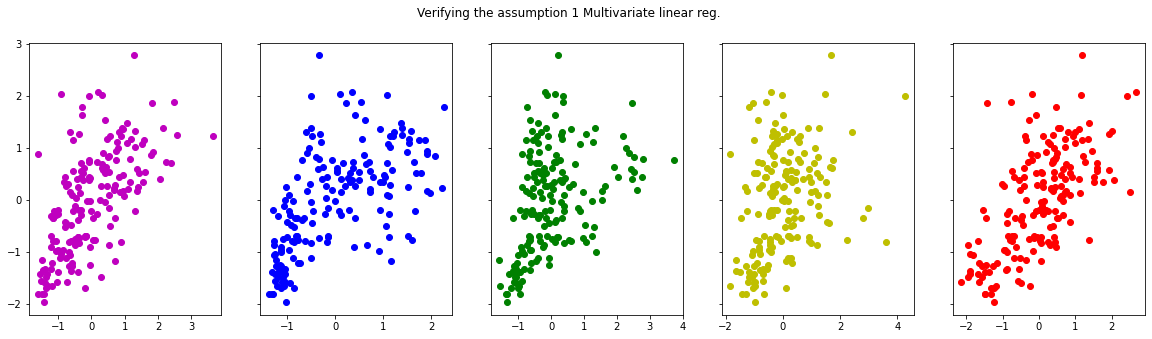

In [20]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

axs[0].scatter(preprocessing.scale(data_per_zcta['pubtrans_bus_commute']), preprocessing.scale(data_per_zcta['pos_per_100000']), s=None, c='m', marker=None)
axs[1].scatter(preprocessing.scale(data_per_zcta['essentialworker_drove']), preprocessing.scale(data_per_zcta['pos_per_100000']), s=None, c='b', marker=None)
axs[2].scatter(preprocessing.scale(data_per_zcta['one_over_medincome']), preprocessing.scale(data_per_zcta['pos_per_100000']), s=None, c='g', marker=None)
axs[3].scatter(preprocessing.scale(data_per_zcta['Perc of not insured']), preprocessing.scale(data_per_zcta['pos_per_100000']), s=None, c='y', marker=None)
axs[4].scatter(preprocessing.scale(data_per_zcta['avg_hhold_size']), preprocessing.scale(data_per_zcta['pos_per_100000']), s=None, c='r', marker=None)

fig.suptitle('Verifying the assumption 1 Multivariate linear reg.')

In [21]:
#dataframe standardized data of variables (pubtrans_bus_commute, essentialworker_drove, one_over_medincome, perc_not_insured, avg_hhold_size)

pubtrans_commuters_st = preprocessing.scale(data_per_zcta['pubtrans_bus_commute'])
workers_drove_st= preprocessing.scale(data_per_zcta['essentialworker_drove'])
one_over_medincome_st = preprocessing.scale(data_per_zcta['one_over_medincome'])
Perc_not_insured_st = preprocessing.scale(data_per_zcta['Perc of not insured'])
avg_hholes_size_st= preprocessing.scale(data_per_zcta['avg_hhold_size'])
pos_per_100000_st = preprocessing.scale(data_per_zcta['pos_per_100000'])

data3_st = {'Zcta' : complete_data_per_zcta["zcta"],
            'pubtrans_commuters' : pubtrans_commuters_st, 
            'workers_driving' : workers_drove_st,
            'one_over_medincome' : one_over_medincome_st,
            'Not insured perc' : Perc_not_insured_st, 
            'Avg households size' : avg_hholes_size_st,
            'Positive cases per 100000' : pos_per_100000_st}

df3 = pd.DataFrame(data3_st)

#define randomly the trainset and dataset
train3, test3 = train_test_split(df3, test_size=0.3)

regr3 = linear_model.LinearRegression()

X_train3 = train3[["pubtrans_commuters", "workers_driving", "one_over_medincome", "Not insured perc", "Avg households size"]]
y_train3 = train3["Positive cases per 100000"]
regr3.fit(X_train3, y_train3)

#X_var3 = df3[["pubtrans_commuters", "workers_driving", "one_over_medincome", "Not insured perc", "Avg households size"]]
#y_var3 = df3['Positive cases per 100000']
#regr3.fit(X_var3, y_var3)

params = regr.coef_

In [22]:
# Create the test features dataset (X_test) which will be used to make the predictions.
X_test3 = test3[["pubtrans_commuters", "workers_driving", "one_over_medincome", "Not insured perc", "Avg households size"]].values 
y_test3 = test3["Positive cases per 100000"].values

close_predictions3 = regr.predict(X_test3)
#close_predictions3 = regr3.predict(X_var3)

MSE: 0.5184954547707302
RMSE: 0.7200662849840493
R^2 : 0.4170226842328285
R^2 adjusted : 0.3562958805070815
Multivariate regression coefficients are:  [-0.04839406  0.13210804  0.17527996  0.04197866  0.68080876]


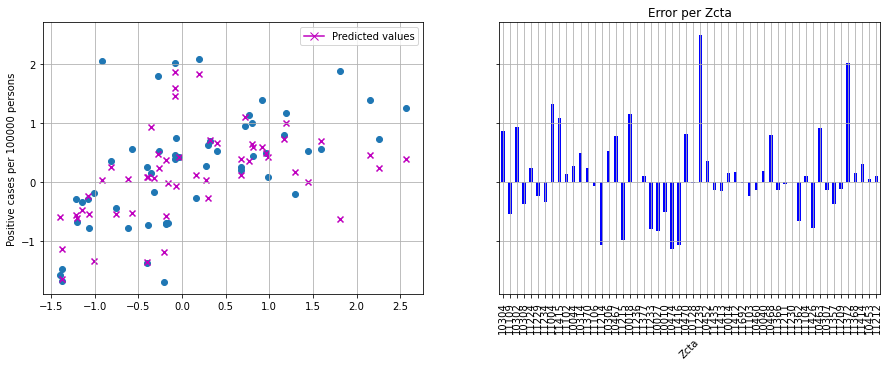

In [23]:
print("MSE:", mean_squared_error(y_test3,close_predictions3))
print("RMSE:", np.sqrt(mean_squared_error(y_test3,close_predictions3)))

n=len(y_test3) #sample size on which we're computing the R^2 value
p=5 #number of indipendent variables used for the regression

r_square3 =r2_score(y_test3,close_predictions3)
r_square3_adj = 1 - (1-r_square3)*(n-1)/(n-p-1)
print("R^2 :", r_square3)
print("R^2 adjusted :", r_square3_adj)
print("Multivariate regression coefficients are: ", params)


# Create a dataframe that output the zcta, the Actual and the predicted value

df_output3 = pd.DataFrame({'Zcta': test3['Zcta'] ,'Actual': y_test3, 'Predicted': close_predictions3})
df_output3.set_index('Zcta',inplace=True)

fig,ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True) 
ax[0].scatter(X_test3[:,0], y_test3)
ax[0].scatter(X_test3[:,0], close_predictions3, color = 'm', marker='x')
markers = mlines.Line2D([], [], color='m', marker='x', markersize=8, label='Predicted values')
ax[0].legend(handles=[markers])
ax[0].set_ylabel('Positive cases per 100000 persons')
ax[0].grid()
      
error_3 = df_output3['Actual'] - df_output3['Predicted']
# Plot the error term between the actual and predicted values
ax[1] = error_3.plot(kind='bar', color='blue')
ax[1].set_xlabel('Zcta', rotation=45)
ax[1].set_title('Error per Zcta')


plt.grid()
plt.show()

Results are coherent with the results of ref. papers, in which effectively workers driving and one over median income are associated to bigger parameters in the multivariate linear regression, followed by the average number of persons per households and commuters using public transports. The smallest parameter in the regression is associated to the percentage of not insured people per ZCTA.

##   <center> Multiple regression model

Multiple regression model.
    
Let's now perform a multivariate regression for the whole set of socio-demographic data to predict the value of number of positive to the antibody test every 100000 persons, i.e. "pos_per_100000" in the dataframe, to evaluate which among these predictors has significant coefficients.

I've ignored variables as : Positive cases, Total tests, Perc Positive and testing_ratio givend the fact that are health data related to the outcome of positivity to the antibody tests; median_rent variable has been excluded since there's some missing values; also qualitative varaibles as zcta number, geometry, Borough and Neighborough name' and variables that otherwise will be redundant as grocers, res_vol_zctadensity and res_vol_popdensity.
I've excuded from the set of the predictors also variables related to one_over_medincome ('undemployed' or indicatiors such as 'snap_hholds', 'fpl_150' refer to the statal aid given to families with low annual median income).
    
'Pop density', 'workhome_commute', 'total households', 'pubtrans_ferrysubway_commute', the average number of workers over 16 years old and informations about the ethnicity have no linear correletion with the predicted value.
    
A low p-value ($< 0.05$) given in the model is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable.
Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response.
    

In [74]:
data_per_zcta = pd.read_csv("/home/claudia/Scrivania/Tesi NYC pandemic /COVID_19_data_Rstudio/Complete_data_per_zipcodes.csv")

x_shapes = gpd.read_file("/home/claudia/Scrivania/Tesi NYC pandemic /COVID_19_data_Rstudio/shapes/shapes.shp")
x_shapes['zcta']=pd.to_numeric(x_shapes['zcta'])

complete_data_per_zcta = x_shapes.merge(data_per_zcta, on='zcta') #file data with geometry information

#now let's construct the dataframe with the whole sets of predictors for Percent pos 100000, exluding the trivial ones
complete_data_per_zcta.rename(columns={'Positive': 'Positive cases'}, inplace=True)
complete_data_per_zcta.rename(columns={'Total': 'Total tests'}, inplace=True)
complete_data_per_zcta.rename(columns={'modzcta_cum_perc_pos': 'Perc Positive'}, inplace=True)
complete_data_per_zcta.rename(columns={'total_commute1': 'Tot commuters'}, inplace=True)
complete_data_per_zcta.rename(columns={'not_insured': 'Perc of not insured'}, inplace=True)                

complete_data_per_zcta.drop(['geometry', 'Borough', 'Neighborhood'], axis='columns', inplace=True)
complete_data_per_zcta_std1 = pd.DataFrame(StandardScaler().fit_transform(complete_data_per_zcta), columns = complete_data_per_zcta.columns)

Text(0.5, 0.98, 'Verifying the assumption 1 Multivariate linear reg.')

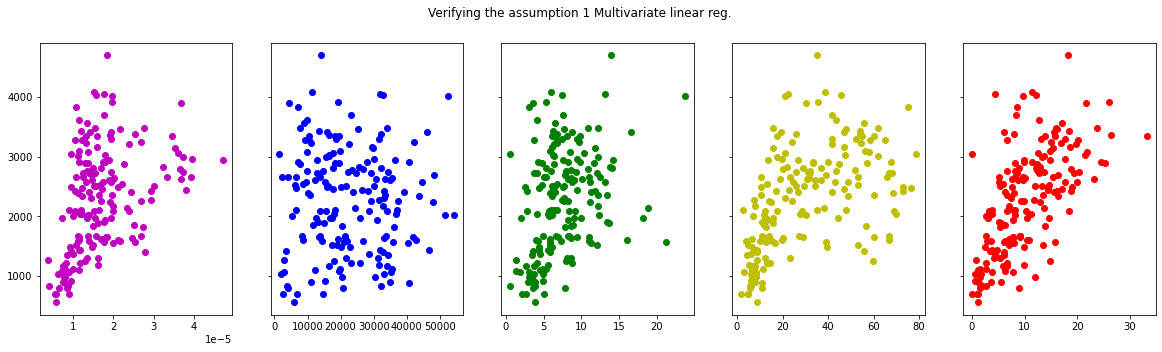

In [75]:
#Let's verify the linearity assumption
fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

axs[0].scatter(complete_data_per_zcta['one_over_medincome'],complete_data_per_zcta['pos_per_100000'], s=None, c='m', marker=None)
axs[1].scatter(complete_data_per_zcta['Tot commuters'],complete_data_per_zcta['pos_per_100000'], s=None, c='b', marker=None)
axs[2].scatter(complete_data_per_zcta['Perc of not insured'],complete_data_per_zcta['pos_per_100000'], s=None, c='g', marker=None)
axs[3].scatter(complete_data_per_zcta['drove_commute'],complete_data_per_zcta['pos_per_100000'], s=None, c='y', marker=None)
axs[4].scatter(complete_data_per_zcta['pubtrans_bus_commute'],complete_data_per_zcta['pos_per_100000'], s=None, c='r', marker=None)

fig.suptitle('Verifying the assumption 1 Multivariate linear reg.')

In [76]:
# X predictors, Y predicted using the standardized data
#X2 = complete_data_per_zcta[['total_pop1', 'total_hholds1', 'over16total_industry1', 'Tot commuters', 'drove_commute', 'pubtrans_bus_commute', 'pubtrans_ferrysubway_commute',  'taxi_commute','bicycle_commute', 'walked_commute','workhome_commute','unemployed','hisplat_raceethnic', 'nonhispLat_white_raceethnic', 'nonhispLat_black_raceethnic', 'nonhispLat_amerindian_raceethnic', 'nonhispLat_asian_raceethnic', 'age65_plus', 'Perc of not insured', 'snap_hholds', 'fpl_150', 'not_quarantined_jobs', 'pop_density', 'essentialworker_drove','essentialworker_pubtrans','grocers_per_1000', 'didnot_workhome_commute','avg_hhold_size','one_over_grocers_per_1000', 'one_over_medincome']]
X = complete_data_per_zcta[['Tot commuters','drove_commute', 'pubtrans_bus_commute','essentialworker_drove','essentialworker_pubtrans','avg_hhold_size','one_over_grocers_per_1000', 'one_over_medincome','Perc of not insured', 'total_pop1']]
y = complete_data_per_zcta['pos_per_100000']

In [77]:
## fit a OLS model with intercept on the predictors
X=ssm.add_constant(X) 
model= ssm.OLS(y,X).fit()  
predictions= model.summary()

predictions

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         pos_per_100000   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     29.21
Date:                Wed, 23 Dec 2020   Prob (F-statistic):           9.68e-32
Time:                        17:30:29   Log-Likelihood:                -1360.0
No. Observations:                 177   AIC:                             2742.
Df Residuals:                     166   BIC:                             2777.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -8.2396    358.639     -0.023      0.982    -716.321     699.841
Tot commuters                -0.0052      0.021     -0.251      0.802      -0.047       0.036
drove_commute               -14.9018     10.630     -1.402      0.163     -35.890       6.087
pubtrans_bus_commute         23.7821      9.470      2.511      0.013       5.085      42.479
essentialworker_drove       107.3117     38.316      2.801      0.006      31.662     182.962
essentialworker_pubtrans     12.9933     19.138      0.679      0.498     -24.793      50.779
avg_hhold_size              343.8121    141.679      2.427      0.016      64.087     623.538
one_over_grocers_per_1000    15.1193      7.772      1.945      0.053      -0.225      30.463
one_over_medincome         2.475e+07   1.06e+07      2.336      0.021    3.83e+06    4.57e+07
Perc of not insured          16.0372     16.990      0.944      0.347     -17.508      49.582
total_pop1                    0.0002      0.010      0.020      0.984      -0.019       0.020
==============================================================================
Omnibus:                       20.263   Durbin-Watson:                   1.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.322
Skew:                           0.776   Prob(JB):                     5.23e-06
Kurtosis:                       3.944   Cond. No.                     1.56e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Given the values of P and cofficients of the regression, most influencing variables on the outcome are: 
- pubtrans_bus_commute;
- essentialworker_drove; 
- avg_hhold_size;
- one_over_medincome; 

These could be eventually the involved variables in the creation of an infection risk index.

In particular, given this model, the most important predictors among this is the indicator of poverty i.e. one over median income, followed by the average size of each household.

So let's try now to predict our data of positive cases per 100000 persons per zcta and look at the efficiency of the prediction:

In [78]:
train_set, test_set = train_test_split(complete_data_per_zcta, test_size=0.2)

regression = linear_model.LinearRegression()

X_train_set = train_set[['pubtrans_bus_commute','essentialworker_drove','avg_hhold_size','one_over_medincome']]
y_train_set = train_set['pos_per_100000']
regression.fit(X_train_set, y_train_set)
parameters = regression.coef_

#predictions
X_test_set = test_set[['pubtrans_bus_commute','essentialworker_drove','avg_hhold_size','one_over_medincome']].values 
y_test_set = test_set['pos_per_100000'].values

predicted = regression.predict(X_test_set)

MSE: 298290.1091665927
RMSE: 546.1594173559517
R^2 : 0.5851016752567031
R^2 adjusted : 0.5315664075478905
Multivariate regression coefficients are:  [2.18450358e+01 5.57925215e+01 4.48356742e+02 3.46367556e+07]


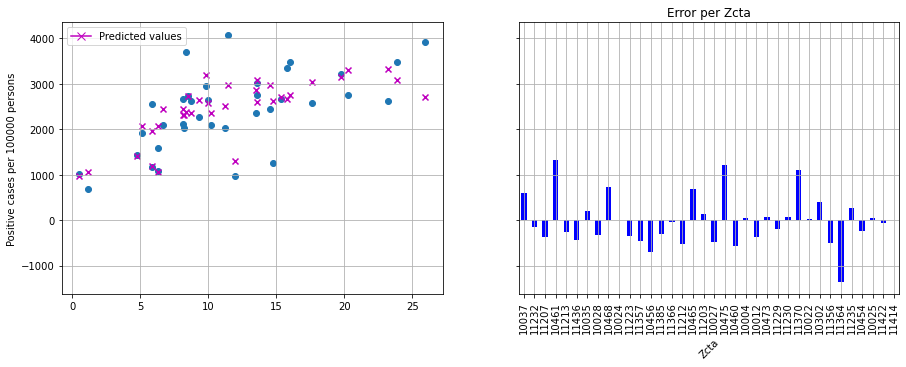

In [79]:
print("MSE:", mean_squared_error(y_test_set,predicted))
print("RMSE:", np.sqrt(mean_squared_error(y_test_set,predicted)))

n=len(y_test_set) #sample size on which we're computing the R^2 value
p=4 #number of indipendent variables used for the regression

erre_square=r2_score(y_test_set,predicted)
erre_square_adj = 1 - (1-erre_square)*(n-1)/(n-p-1)
print("R^2 :", erre_square)
print("R^2 adjusted :", erre_square_adj)
print("Multivariate regression coefficients are: ", parameters)


# Create a dataframe that output the zcta, the Actual and the predicted value
dataf_output= pd.DataFrame({'Zcta': test_set['zcta'] ,'Actual': y_test_set, 'Predicted': predicted})
dataf_output.set_index('Zcta',inplace=True)

fig,ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True) 
ax[0].scatter(X_test_set[:,0], y_test_set)
ax[0].scatter(X_test_set[:,0], predicted, color = 'm', marker='x')
markers = mlines.Line2D([], [], color='m', marker='x', markersize=8, label='Predicted values')
#markers = mlines.Line2D([], [], color='b', marker='o', markersize=8, label='Test set values')
ax[0].legend(handles=[markers])
ax[0].set_ylabel('Positive cases per 100000 persons')
ax[0].grid()
      
error_3 = dataf_output['Actual'] - dataf_output['Predicted']
# Plot the error term between the actual and predicted values
ax[1] = error_3.plot(kind='bar', color='blue')
ax[1].set_xlabel('Zcta', rotation=45)
ax[1].set_title('Error per Zcta')


plt.grid()
plt.show()

### <center> Plots of NYC health data per zipcode at 1st October.

In [82]:
data_per_zcta = pd.read_csv("/home/claudia/Scrivania/Tesi NYC pandemic /COVID_19_data_Rstudio/Complete_data_per_zipcodes.csv")

x_shapes = gpd.read_file("/home/claudia/Scrivania/Tesi NYC pandemic /COVID_19_data_Rstudio/shapes/shapes.shp")
x_shapes['zcta']=pd.to_numeric(x_shapes['zcta'])

complete_data_per_zcta = x_shapes.merge(data_per_zcta, on='zcta') #file data with geoometry information
data_per_boro = data_per_zcta.groupby(["Borough"]).mean()


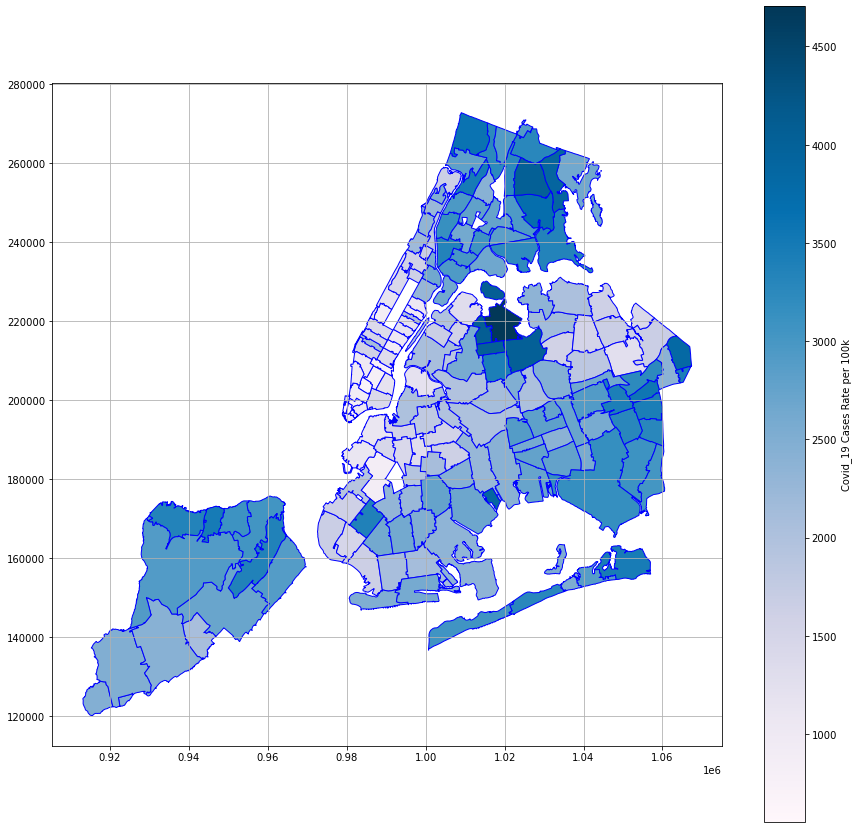

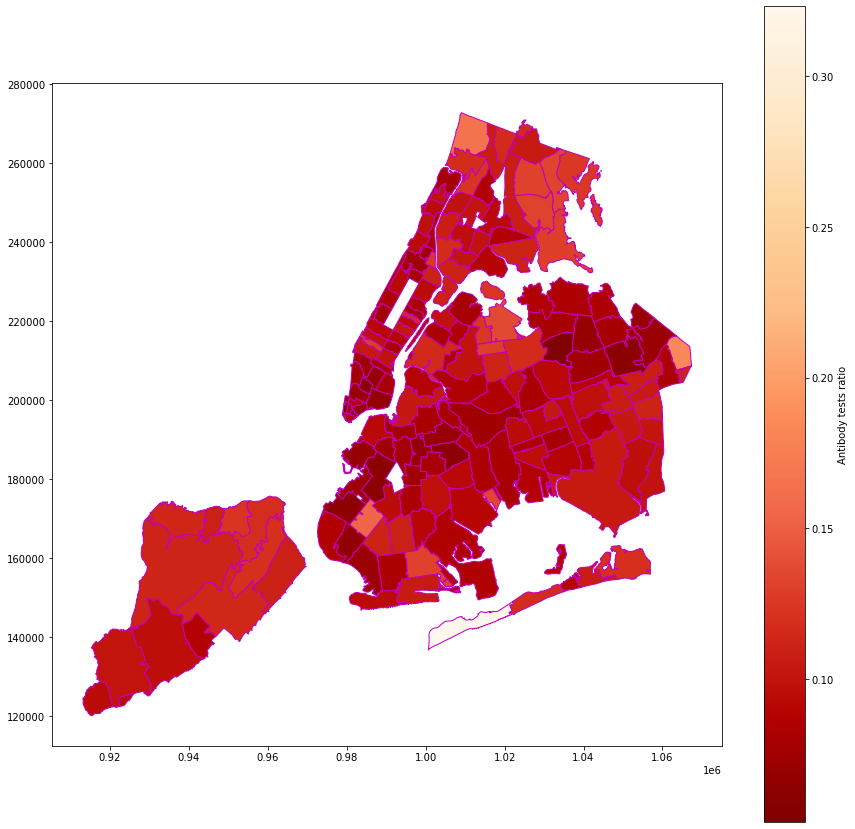

In [83]:
fig,ax = plt.subplots(figsize=(15,15))
complete_data_per_zcta.plot(column='pos_per_100000', cmap='PuBu', ax=ax, figsize=(8,8), edgecolor='b', legend=True, legend_kwds={'label': "Covid_19 Cases Rate per 100k",'orientation': "vertical"})
plt.grid()

fig2, ax = plt.subplots(figsize=(15,15))
complete_data_per_zcta.plot(column='testing_ratio', cmap="OrRd_r", ax = ax, figsize=(8,8), edgecolor='m', legend=True, legend_kwds={'label' : 'Antibody tests ratio', 'orientation': 'vertical'})